# Predicting Tensile Strengths of Alloys Using Machine Learning

This notebook uses over 350 alloys to model tensile strengths based on alloy compositions, and uses the model to predict tensile strengths of new compounds. It creates features based on the composition of each entry, trains a random forest model, and then uses the model to predict new compound tensile strengths.

Alloy data taken from [here](https://www.nickelinstitute.org/~/media/files/technicalliterature/propertiesofsomemetalsandalloys_297_.pdf)

In [1]:
#Before loading the dataset, we import the required libraries and packages

import pandas as pd         #pandas provides easy-to-use data structures and data analysis tools
import numpy as np          #numpy provides numerical tools
from itertools import combinations,permutations        #helps create new compounds
from sklearn.model_selection import train_test_split   #used to create a test set for checking accuracy
from sklearn.linear_model import LinearRegression #Simple least squares regression for benchmarking
from sklearn.ensemble import RandomForestRegressor     #the randomforest used for training the model
from sklearn.metrics import mean_absolute_error as mae #This is the metric we use to check error/accuracy
import matplotlib.pyplot as plt

C:\Users\virinchi\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


## Loading the dataset using pandas from the local folder

In [2]:
file_location = r'C:\Users\virinchi\Downloads\finaldata_alloy_comp.csv'
#change file_location in the above line accordingly.
# ex: file_location = r'C:\Users\Sushma\TSproject\finaldata_alloy_comp.csv'
data = pd.read_csv(file_location) #loads the data into a pandas dataframe

Having a brief look at the data that is loaded. head() method outputs the top 5 rows of the dataset

In [3]:
data.head()

,composition,m1,m1%,m2,m2%,m3,m3%,m4,m4%,m5,...,m7%,m8,m8%,m9,m9%,m10,m10%,m11,m11%,TS
0,Cu99.90,Cu,99.90,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,32.0
1,"Cu98.05,Be1.7,Co0.25",Cu,98.05,Be,1.70,Co,0.25,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,165.0
2,"Cu97.85,Be1.9,Co0.25",Cu,97.85,Be,1.90,Co,0.25,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,175.0
3,"Cu96.9,Be0.6,Co2.5",Cu,96.90,Be,0.60,Co,2.50,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,110.0
4,"Cu97.07,Be0.38,Co1.55,Ag1",Cu,97.07,Be,0.38,Co,1.55,Ag,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,110.0


# Creating new compounds
Creating over 18,000 random combinations of three metals with random weights

## Create random weights
Initializing random weights for components that sum up to 100

In [4]:
def wt():
    weights = np.random.random(3)
    weights /= weights.sum();weights*=100;weights = weights.round(2)
    return weights

## Create random metal-weight combinations of size 3

In [5]:
metals = []
for column in 'm1 m2 m3 m4 m5 m6 m7 m8 m9 m10 m11'.split(' '):
    metals.extend(data[column].dropna().drop_duplicates())
    metals = list(set(metals))
metals = np.asarray(metals)
metals[metals!='nan']
metals.sort()

new_comps = []
for i in combinations(metals,3):
    new_comps.append(','.join([m+str(n) for m,n in zip(i,wt())]))
print('Number of new randomly generated components:',len(new_comps))

Number of new randomly generated components: 19600


This created 18424 new alloy combinations

In [6]:
# A random sample of 15 items from the above list of new compounds
import random
print(random.sample(new_comps, 15))

['Fe51.22,Re45.7,Zn3.09', 'As54.69,Au0.53,Cc44.78', 'Cb0.21,Pd13.91,W85.88', 'B43.0,C12.11,Fe44.89', 'Se32.61,W37.61,Zr29.78', 'Ir3.94,N30.53,pb65.52', 'Hf18.95,Ma45.08,Ru35.97', 'Pb44.34,Sb0.4,Zn55.27', 'Ag45.93,La15.81,U38.26', 'Ag43.84,La48.68,Ru7.48', 'Pb67.0,Rh10.83,V22.17', 'In21.6,Pd43.43,Zn34.98', 'Re48.71,Sb11.08,V40.21', 'S14.36,Ta29.85,U55.79', 'Ir36.97,Mo8.0,U55.03']


## Create a dataframe new compounds

In [7]:
#Create a pandas dataframe from new component list so that it can be passed to the model for prediction
new = pd.DataFrame({'composition':new_comps})
expanded = new['composition'].str.split(',', expand=True)
for column in expanded.columns:
    m = expanded[column].str.extract(r'([a-zA-Z]+)([0-9\.]+)')
    m.columns = ['m'+str(column+1),'m'+str(column+1)+'%']
    m['m'+str(column+1)+'%'] = m['m'+str(column+1)+'%'].astype('float')
    new = pd.concat([new,m],axis='columns')

In [8]:
# A look at the new dataframe
new.head()

,composition,m1,m1%,m2,m2%,m3,m3%
0,"Ag21.75,Al31.46,As46.8",Ag,21.75,Al,31.46,As,46.80
1,"Ag44.45,Al0.13,Au55.42",Ag,44.45,Al,0.13,Au,55.42
2,"Ag64.96,Al27.34,B7.7",Ag,64.96,Al,27.34,B,7.70
3,"Ag1.23,Al52.25,Be46.52",Ag,1.23,Al,52.25,Be,46.52
4,"Ag54.18,Al10.73,Bi35.09",Ag,54.18,Al,10.73,Bi,35.09


## data preprocessing

After loading the dataset, the columns m1, m2,..... need to be one-hot-encoded to suit learning algorithms. This helps convert the categorical columns into numeric columns for model building. This can be done by using the 'get_dummies()' method of pandas

In [9]:
#concatenating the newly generated compounds dataframe to capture their categories
data1 = pd.concat([data,new])

C:\Users\virinchi\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  


In [10]:
for col in 'm1 m2 m3 m4 m5 m6 m7 m8 m9 m10 m11'.split(' '):
    data1[col] = data1[col].astype('category')

In [11]:
df = pd.get_dummies(data1.drop(['composition'],axis='columns')) #creates a new dataframe df that creates new dummy columns

In [12]:
# a look at the new data
df.head()

,TS,m1%,m10%,m11%,m2%,m3%,m4%,m5%,m6%,m7%,...,m9_B,m9_C,m9_Cb,m9_H,m9_O,m9_Si,m9_Ta,m9_Ti,m9_V,m9_Zr
0,32.0,99.90,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
1,165.0,98.05,NaN,NaN,1.70,0.25,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
2,175.0,97.85,NaN,NaN,1.90,0.25,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
3,110.0,96.90,NaN,NaN,0.60,2.50,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
4,110.0,97.07,NaN,NaN,0.38,1.55,1.0,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0


data in 24 columns got spread into 276 columns after one-hot-encoding

In [13]:
# A look at all the 276 new columns created
for i in df.columns:
    print(i,end=' ')

TS m1% m10% m11% m2% m3% m4% m5% m6% m7% m8% m9% m1_Ag m1_Al m1_As m1_Au m1_B m1_Be m1_Bi m1_C m1_Cb m1_Cc m1_Cd m1_Co m1_Cr m1_Cu m1_Fe m1_H m1_Hf m1_In m1_Ir m1_La m1_Ma m1_Mg m1_Mn m1_Mo m1_N m1_Ni m1_O m1_P m1_Pb m1_Pd m1_Pt m1_Re m1_Rh m1_Ru m1_S m1_Sb m1_Se m1_Si m1_Sn m1_Ta m1_Te m1_Th m1_Ti m1_U m1_V m1_W m1_Y m1_Zn m1_Zr m1_pb m10_C m10_Fe m10_O m10_Zr m11_B m11_C m11_Co m11_Cu m2_Ag m2_Al m2_As m2_Au m2_B m2_Be m2_Bi m2_C m2_Cb m2_Cc m2_Cd m2_Co m2_Cr m2_Cu m2_Fe m2_H m2_Hf m2_In m2_Ir m2_La m2_Ma m2_Mg m2_Mn m2_Mo m2_N m2_Ni m2_O m2_P m2_Pb m2_Pd m2_Pt m2_Re m2_Rh m2_Ru m2_S m2_Sb m2_Se m2_Si m2_Sn m2_Ta m2_Te m2_Th m2_Ti m2_U m2_V m2_W m2_Y m2_Zn m2_Zr m3_Al m3_As m3_Au m3_B m3_Be m3_Bi m3_C m3_Cb m3_Cc m3_Cd m3_Co m3_Cr m3_Cu m3_Fe m3_H m3_Hf m3_In m3_Ir m3_La m3_Ma m3_Mg m3_Mn m3_Mo m3_N m3_Ni m3_O m3_P m3_Pb m3_Pd m3_Pt m3_Re m3_Rh m3_Ru m3_S m3_Sb m3_Se m3_Si m3_Sn m3_Ta m3_Te m3_Th m3_Ti m3_U m3_V m3_W m3_Y m3_Zn m3_Zr m3_pb m4_Ag m4_Al m4_As m4_B m4_C m4_Cb m4_Cc m4_C

In [14]:
df.fillna(0,inplace=True) #this fills all the blank cells in the weights columns with zero
df.head()

,TS,m1%,m10%,m11%,m2%,m3%,m4%,m5%,m6%,m7%,...,m9_B,m9_C,m9_Cb,m9_H,m9_O,m9_Si,m9_Ta,m9_Ti,m9_V,m9_Zr
0,32.0,99.90,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
1,165.0,98.05,0.0,0.0,1.70,0.25,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
2,175.0,97.85,0.0,0.0,1.90,0.25,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
3,110.0,96.90,0.0,0.0,0.60,2.50,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
4,110.0,97.07,0.0,0.0,0.38,1.55,1.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0


After capturing categories, separating the newly generated compounds from the original alloy dataframe

In [15]:
new_dum = df[df['TS'] == 0]
df = df[df['TS'] != 0]
new_dum.drop(['TS'],axis='columns',inplace=True)

## Defining the target variable and splitting data into train and test sets

Supervised machine learning models require seggregation between the predictor variables and target variable. The original datafrem df's predictor variables are stored in the dataframe X, while the target is stored in y

In [16]:
X = df.drop(['TS'],axis='columns')
y = df['TS']

Splitting the data into train and test sets helps check the model performance on unseen data. The code in the below cell splits the predictors and target dataframes into 'train predictors', 'train targets', 'test predictors', and 'test targets'.

In [17]:
X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=0)

## Train and test sets

A look at the test and train sets created above

In [18]:
# Alloys used in the train dataset
train_data = pd.DataFrame({'composition': data.loc[X_train.index]['composition'], 'Actual_TS':data.loc[X_train.index]['TS']})
train_data.head()

,composition,Actual_TS
132,"Ni50,Ti50",125.0
66,"Al95.0,Si5",23.0
261,"Fe75.03,Cr17,Ni7,Ti0.7,Al0.2,C0.07",135.0
12,"Cu89.8,Sn10,P0.2",66.0
120,"Ni95.6,Cu0.5,Fe0.5,Mn0.8,Si1.5,C0.8",57.0


In [19]:
# Alloys in the test dataset
test_data = pd.DataFrame({'composition': data.loc[X_test.index]['composition'], 'Actual_TS':data.loc[X_test.index]['TS']})
test_data.head()

,composition,Actual_TS
6,"Cu70,Zn30",44.0
140,"Ni32,Cr20.5,Fe44.5,C0.05,Ti1.1",92.0
302,"Fe41.43,Cr20.5,Ni29,Cu3.5,Mo2.5,Mn1.5,Si1.5,C0.07",62.0
220,"Fe89.5,Ni4.5,Cr2.1,C2.8,Si0.5,Mn0.6",60.0
90,"Ti81.66,Al6,Sn2,Zr4,Mo6,C0.04,Fe0.15,N0.02,H0....",160.0


# Building the model
## Simple Least Squares Regression

Now that the train and test datasets are ready, below cell creates a linear regression model instance using LinearRegression class from scikit learn

In [20]:
lm = LinearRegression()

## Fitting the linear model

In [21]:
lm.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In the above cell, the linear regression algorithm was fit on the train predictors and train target to learn the model. The learnt model is then used to predict the target variable (Tensile Strength) using train predictors and error is noted. 

Later, the same model is used to predict the test target variable using the test predictors. The last step gives us the metric to evaluate the model on heldout data.

In [22]:
lm.score(X_train,y_train) #this gives the coefficient of determination

0.9161267835161433

## Predicting train target using the model to evaluate how the model performs on seen data

In [23]:
lm_train_preds = lm.predict(X_train)
print('Linear Regression train error: ',mae(y_train,lm_train_preds))

Linear Regression train error:  8.5266499330042


## Checking model performance on unseen data (the test set)

In [24]:
lm_test_preds = lm.predict(X_test)
print('Linear Regression test error : ',mae(y_test,lm_test_preds))

Linear Regression test error :  47861694442.32547


## Function for plotting error vs sample size

In [76]:
def plotter(model, algorithm):
    sample_size = np.arange(0.1,0.9,0.01)
    train_error = []
    test_error = []
    
    for n in sample_size:
        train_sample = df.sample(frac=n, replace=True,random_state=6)
        X_sample = train_sample.drop(['TS'],axis='columns')
        y_sample = train_sample['TS']
        
        X_sm_train,X_sm_test,y_sm_train,y_sm_test = train_test_split(X_sample,y_sample,random_state=0)
        
        model.fit(X_sm_train,y_sm_train)
        
        train_sm_preds = model.predict(X_sm_train)
        train_err = mae(y_sm_train,train_sm_preds)
        train_error.append(train_err)
        
        test_sm_preds = model.predict(X_sm_test)
        test_err = mae(y_sm_test,test_sm_preds)
        test_error.append(test_err)
        
    x_label = sample_size*350
    log_train_error = np.log10(train_error)
    log_test_error = np.log10(test_error)
    plt.figure(figsize=(20,10))
    plt.plot(x_label,log_train_error,'g',label='Log of Train Error')
    plt.plot(x_label,log_test_error,'r',label = 'Log of Test Error')
    title = 'Error vs SampleSize in '+ algorithm
    plt.title(title)
    plt.xlabel('SampleSize')
    plt.ylabel('Log Error')
    plt.legend()
    plt.show()

# Calling the plotter function for linear regression

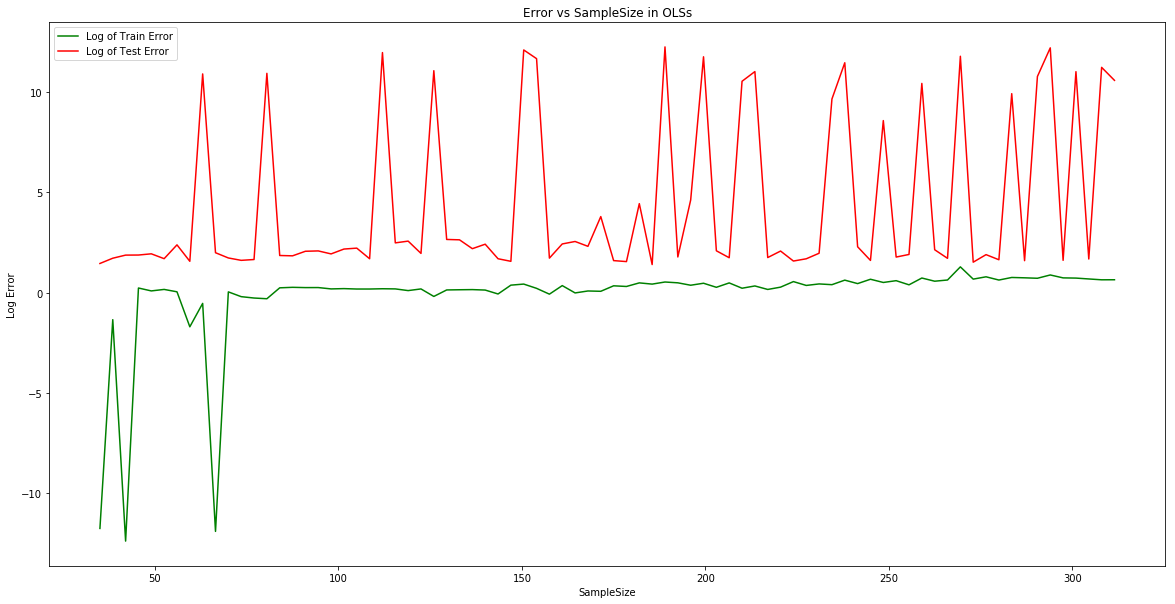

In [77]:
lm_sample = LinearRegression()
plotter(lm_sample,'OLSs')

## Random Forest for Regression

Below cell creates a Random Forest model instance using RandomForestRegressor class from scikit learn

In [44]:
#This code creates a model instance with all the hyperparameters of the random forest model set
rf = RandomForestRegressor(bootstrap=True, max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=9, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=0, verbose=0, warm_start=False)

## Fitting the model

In [45]:
rf.fit(X_train,y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=9, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=0, verbose=0, warm_start=False)

In [46]:
rf.score(X_train,y_train)

0.8656248420999302

In [47]:
estim = [1,2,3,4,5,7,15,20,25,30,35,40,45,50,55,60,70,75,90,100,110,120,130,140,200,210,220]
training = list()
prediction = list()
for param in estim:
    rf.set_params(n_estimators=param)
    rf.fit(X_train, y_train)
    training.append(mae(y_train,rf.predict(X_train)))
    prediction.append(mae(y_test,rf.predict(X_test)))

i_min_impurity_optim = np.argmax(prediction)
min_imp_optim = estim[i_min_impurity_optim]

In [48]:
for_plot = pd.DataFrame({'Training':training,'Prediction':prediction})
for_plot.to_csv(r'C:\Users\Virinchi\Downloads\for_plot.csv',index=False)

## Predicting train target using the model to evaluate how the model performs on seen data

In [49]:
rf_train_preds = rf.predict(X_train)
print('RF train error: ',mae(y_train,rf_train_preds))

RF train error:  13.247227393678518


## Checking model performance on unseen data (the test set)

In [50]:
rf_test_preds = rf.predict(X_test)
print('RF test error : ',mae(y_test,rf_test_preds))

RF test error :  18.43656275455026


The error on unseen data is 18.43

In [51]:
train_data['Predicted_TS'] = rf_train_preds.round(2)
test_data['Predicted_TS'] = rf_test_preds.round(2)

train_data.to_csv(r'C:\Users\virinchi\Downloads\Train_Actual_vs_Preds.csv',index=False)
test_data.to_csv(r'C:\Users\virinchi\Downloads\Test_Actual_vs_Preds.csv',index=False)

## calling the plotter function with Random Forest model

In [52]:
rf_sample_model = RandomForestRegressor(bootstrap=True, max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=9, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=0, verbose=0, warm_start=False)

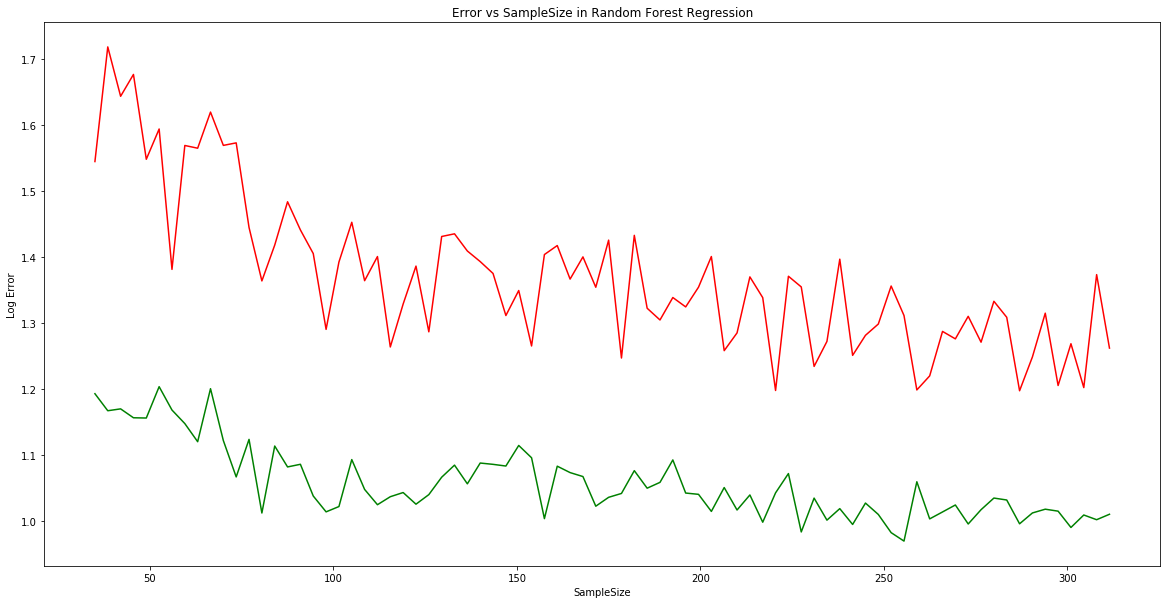

In [53]:
plotter(rf_sample_model,'Random Forest Regression')

# Predicting tensile strengths of new compounds
Passing the newly created compounds data to the model to predict their tensile strengths

In [54]:
predictd_TS = rf.predict(new_dum)

In [55]:
#adding the predicted tensile strengths as a column to the new compounds dataframe
new['Predicted_TS'] = predictd_TS.round(2)

In [56]:
# A look at the new final dataframe
new.head()

,composition,m1,m1%,m2,m2%,m3,m3%,Predicted_TS
0,"Ag21.75,Al31.46,As46.8",Ag,21.75,Al,31.46,As,46.80,52.69
1,"Ag44.45,Al0.13,Au55.42",Ag,44.45,Al,0.13,Au,55.42,51.05
2,"Ag64.96,Al27.34,B7.7",Ag,64.96,Al,27.34,B,7.70,56.88
3,"Ag1.23,Al52.25,Be46.52",Ag,1.23,Al,52.25,Be,46.52,52.02
4,"Ag54.18,Al10.73,Bi35.09",Ag,54.18,Al,10.73,Bi,35.09,49.29


## Exporting the new compounds dataframe as a csv document to the local drive

In [58]:
new.to_csv(r'C:\Users\virinchi\Downloads\New_Compound_Predictions.csv',index=False)
#please replace the above location with your local drive location where you want the file to be exported to

## Using the model to predict new ternary compounds

In [59]:
def predict_TS(metal1,metal1_pct,metal2,metal2_pct,metal3,metal3_pct):
    dct = dict(zip(['m1','m1%','m2','m2%','m3','m3%'],[metal1,metal1_pct,metal2,metal2_pct,metal3,metal3_pct]))
    compound = pd.DataFrame(dct,index=[0])
    comp = pd.get_dummies(compound)
    cols = df.columns.tolist()
    cols.remove('TS')
    for col in comp.columns:
        cols.remove(col)
    c1 = pd.DataFrame(0, index=[0], columns=cols)
    comp_final = pd.concat([comp,c1],axis='columns')
    estimated_TS =  rf.predict(comp_final)[0].round(2)
    return estimated_TS

In [60]:
while True:
    metal1 = input("enter first metal. ex: Ag ")
    metal1_pct = float(input('enter first metal %. ex: 97.8 '))
    metal2 = input("enter second metal. ex: As ")
    metal2_pct = float(input('enter second metal %. ex: 1 '))
    metal3 = input('enter third metal. Ex:Be ')
    metal3_pct = float(input('enter thrid metal %. ex: 1.2 '))
    if metal1_pct + metal2_pct + metal3_pct == 100:
        print('Thank you!')
        break
    else: print('Please make sure the percentages add up to 100')
comp = ",".join([metal1+str(metal1_pct),metal2+str(metal2_pct),metal3+str(metal3_pct)])
pred = predict_TS(metal1,metal1_pct,metal2,metal2_pct,metal3,metal3_pct)
print('')
print("The estimated tensile strength for the compound {} is: {}".format(comp,pred) )

enter first metal. ex: Ag Ag
enter first metal %. ex: 97.8 98
enter second metal. ex: As As
enter second metal %. ex: 1 1
enter third metal. Ex:Be Be
enter thrid metal %. ex: 1.2 1
Thank you!

The estimated tensile strength for the compound Ag98.0,As1.0,Be1.0 is: 46.26
